In [1]:
# !gdown https://drive.google.com/uc?id={'1zZeuAujjlVc1leArrYOqJgFjcwHMG46H'}
# !unzip data3.zip

Downloading...
From: https://drive.google.com/uc?id=1zZeuAujjlVc1leArrYOqJgFjcwHMG46H
To: /content/clouderizer/transferlearningtensorflow/CarND-Behavioral-Cloning-P3/data3.zip
216MB [00:01, 179MB/s]
Archive:  data3.zip
  inflating: data2/driving_log.csv   
   creating: data2/IMG/
  inflating: data2/IMG/center_2019_03_29_14_26_55_149.jpg  
  inflating: data2/IMG/center_2019_03_29_14_26_55_217.jpg  
  inflating: data2/IMG/center_2019_03_29_14_26_55_289.jpg  
  inflating: data2/IMG/center_2019_03_29_14_26_55_362.jpg  
  inflating: data2/IMG/center_2019_03_29_14_26_55_437.jpg  
  inflating: data2/IMG/center_2019_03_29_14_26_55_511.jpg  
  inflating: data2/IMG/center_2019_03_29_14_26_55_579.jpg  
  inflating: data2/IMG/center_2019_03_29_14_26_55_646.jpg  
  inflating: data2/IMG/center_2019_03_29_14_26_55_721.jpg  
  inflating: data2/IMG/center_2019_03_29_14_26_55_796.jpg  
  inflating: data2/IMG/center_2019_03_29_14_26_55_870.jpg  
  inflating: data2/IMG/center_2019_03_29_14_26_55_937.jpg  

In [11]:
!gdown https://drive.google.com/uc?id={'1lFKkpaDp_z0k-6TPTD_XCY-mCiD-0BN9'}
!unzip data4.zip

Downloading...
From: https://drive.google.com/uc?id=1lFKkpaDp_z0k-6TPTD_XCY-mCiD-0BN9
To: /content/clouderizer/transferlearningtensorflow/CarND-Behavioral-Cloning-P3/data4.zip
282MB [00:01, 180MB/s]
Archive:  data4.zip
  inflating: data4/driving_log.csv   
   creating: data4/IMG/
  inflating: data4/IMG/center_2019_03_29_14_26_55_149.jpg  
  inflating: data4/IMG/center_2019_03_29_14_26_55_217.jpg  
  inflating: data4/IMG/center_2019_03_29_14_26_55_289.jpg  
  inflating: data4/IMG/center_2019_03_29_14_26_55_362.jpg  
  inflating: data4/IMG/center_2019_03_29_14_26_55_437.jpg  
  inflating: data4/IMG/center_2019_03_29_14_26_55_511.jpg  
  inflating: data4/IMG/center_2019_03_29_14_26_55_579.jpg  
  inflating: data4/IMG/center_2019_03_29_14_26_55_646.jpg  
  inflating: data4/IMG/center_2019_03_29_14_26_55_721.jpg  
  inflating: data4/IMG/center_2019_03_29_14_26_55_796.jpg  
  inflating: data4/IMG/center_2019_03_29_14_26_55_870.jpg  
  inflating: data4/IMG/center_2019_03_29_14_26_55_937.jpg  

In [30]:
import csv
import cv2
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Conv2D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Cropping2D
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split

In [39]:
def get_csv_lines(path = 'data4'):
    lines = []
    with open('./' + path + '/driving_log.csv') as f:
        reader = csv.reader(f)
        for line in reader:
            lines.append(line)
    return lines

In [40]:
def get_images_and_measurements(lines, path = 'data4'):
    
    images = []
    measurements = []

    for line in lines:
        for i in range(3):
            source_path = line[i]
            filename = source_path.split('\\')[-1]
            current_path = './' + path +'/IMG/' + filename
            image = cv2.imread(current_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
            measurement = float(line[3+i])
            if i == 1:
                measurement += 0.2
            elif i == 2:
                measurement -= 0.2
            measurements.append(measurement)
            
    return images, measurements

In [41]:
def get_data_augmentated(images, measurements):
    augmentated_images, augmentated_measurements = [],[]

    for image, measurement  in zip(images,measurements):
        augmentated_images.append(image)
        augmentated_measurements.append(measurement)
        augmentated_images.append(cv2.flip(image,1))
        augmentated_measurements.append(measurement*-1.0)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    return X_train, y_train

In [43]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for batch_sample in batch_samples:
                images_batch, measurements_batch = get_images_and_measurements(batch_sample)
                images_batch, measurements_batch = get_data_augmentated(images_batch, measurements_batch)
                images.append(images_batch)
                measurements.append(measurements_batch)
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

In [44]:
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/255.0 - 0.5 ,input_shape = (160,320,3)))
    model.add(Cropping2D(cropping = ((70, 25),(0,0))))
    model.add(Conv2D(24,(5,5),strides = (2,2), activation='relu'))
    model.add(Conv2D(36,(5,5),strides = (2,2), activation='relu'))
    model.add(Conv2D(48,(5,5),strides = (2,2), activation='relu'))
    model.add(Conv2D(64,(3,3),strides = (1,1), activation='relu'))
    model.add(Conv2D(64,(3,3),strides = (1,1), activation='relu'))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))

    return model

In [45]:
lines = get_csv_lines('data2')
train_samples, validation_samples = train_test_split(lines, test_size=0.2)
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [47]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_3 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 35, 64)         27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 33, 64)         36928     
__________

In [23]:
model.compile(loss = 'mse', optimizer = 'adam')
history_object = model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, epochs = 5, verbose= 2)
model.save('model.h5')

Instructions for updating:
Use tf.cast instead.
Train on 25248 samples, validate on 6312 samples
Epoch 1/5
 - 33s - loss: 0.1763 - val_loss: 0.1412
Epoch 2/5
 - 26s - loss: 0.1355 - val_loss: 0.1385
Epoch 3/5
 - 28s - loss: 0.1233 - val_loss: 0.1204
Epoch 4/5
 - 27s - loss: 0.1125 - val_loss: 0.1202
Epoch 5/5
 - 28s - loss: 0.0999 - val_loss: 0.1061


In [50]:
model.compile(loss = 'mse', optimizer = 'adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= 
            len(train_samples), validation_data=validation_generator, 
            nb_val_samples=len(validation_samples), nb_epoch=3)
model.save('model.h5')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=4208, epochs=3, validation_steps=1052)`
  after removing the cwd from sys.path.


Epoch 1/3


NameError: name 'shuffle' is not defined

dict_keys(['val_loss', 'loss'])


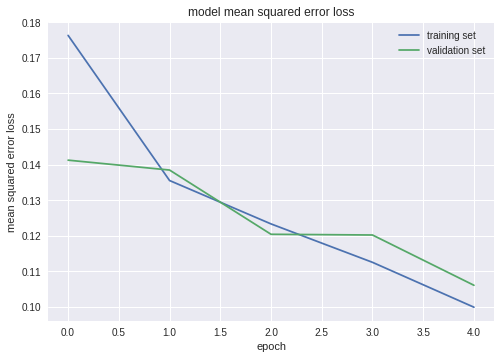

In [24]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()